# EDA: Understanding Cora Dataset
---

## 1.0 Install `torch_geometric` and import libraries

In [ ]:
!pip install torch_geometric

In [ ]:
# Import libraries
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import plotly.graph_objects as go
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True) # create a directory to store the Cora dataset

## 2.0 Cora Dataset
The Cora dataset is a well-known dataset ub tge fuekd if graog research. This consists of 2708 scientific publications classified into one of the seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [ ]:
# Load the dataset
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

The Cora dataset contains `2708` papers, which are represented as nodes in the graph.

In [ ]:
# Nodes
print(f"Number of nodes: {data.num_nodes}")

Number of nodes: 2708


The papers in the Cora dataset have `5429` citation connections, which are represented as edges in the graph. The edge information is unique to graph data.

In [ ]:
# Edges
print(f"Number of edges: {data.num_edges}")

Number of edges: 10556


The number of edges seems to be `10556`. Let’s find out why the number of edges is twice as large as 5429.

In [ ]:
# Check the information
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


<font color='orange'>Important Notes:</font>
The first line of code confirms that there are no nodes not connected by edges, the second line of code shows that there are no self-loops, and the edge count is double the actual count because of the bi-directional edge information included.

In [ ]:
# Retrieve the edge index
edge_index = data.edge_index.numpy() # Index is in Tensor, required to convert into numpy array with numpy()
print(edge_index.shape)
print(edge_index)

(2, 10556)
[[ 633 1862 2582 ...  598 1473 2706]
 [   0    0    0 ... 2707 2707 2707]]


In [ ]:
# Retrieve an edge example
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

We have obtained data in the form of pairs of nodes to which the edges are connected.

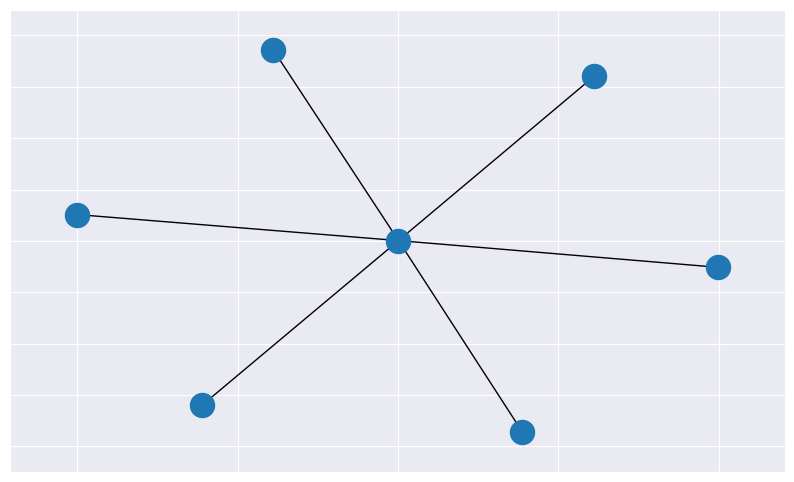

In [ ]:
# Visualize the network centered on this node
node_example = np.unique(edge_example.flatten())

plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False)


## 3.0 Node Degree
Degree in graph theory means the number of edges joining a vertex (node) in a graph.

In [ ]:
# Check the average node degree
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")

Average node degree: 3.90


,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


<Figure size 1000x600 with 0 Axes>

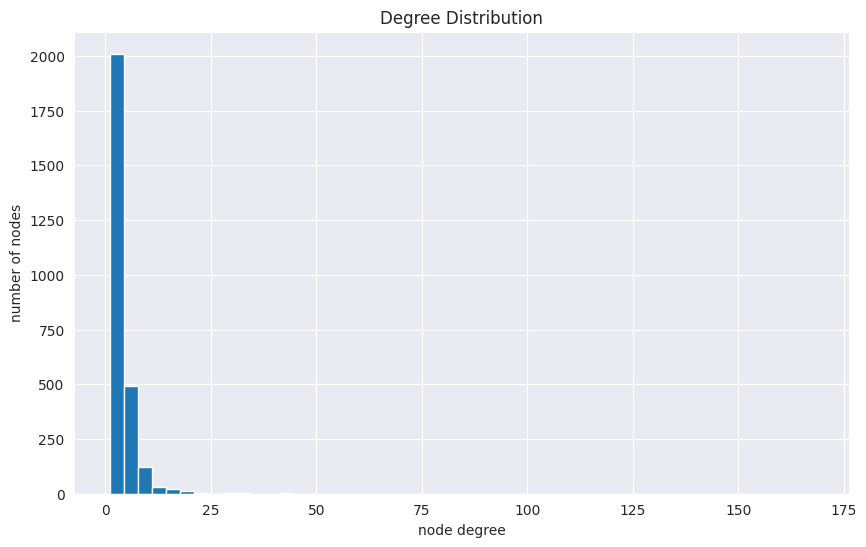

In [ ]:
# Visualize the overall distribution with histogram of the degree
plt.figure(figsize=(10, 6))
G = to_networkx(data, to_undirected=True)
degree_sequence = [d for n, d in G.degree()]

display(pd.DataFrame(pd.Series(degree_sequence).describe()).transpose().round(2))

plt.figure(figsize=(10, 6))
plt.hist(degree_sequence, bins=50)
plt.title("Degree Distribution")
plt.xlabel("node degree")
plt.ylabel("number of nodes")
plt.show()

<font color='orange'>Important Note:</font> A high degree means that they are connected to many nodes (papers). In other words, nodes with high degrees are likely to be important.

threshold 0.011821204285186553


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


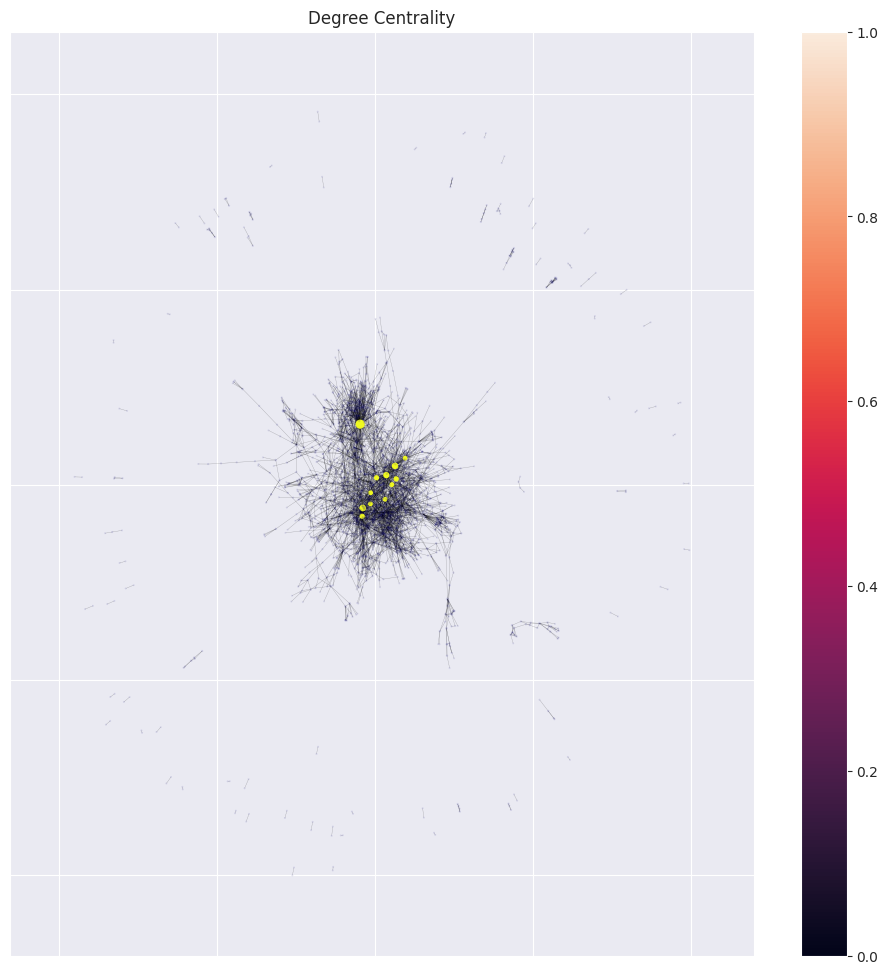

In [ ]:
# Plot top 10 nodes with the highest degree are located
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G) # degree centrality
node_size = list(map(lambda x: x * 500, cent.values())) # scale node size by degree
cent_array = np.array(list(cent.values())) # convert to numpy array
threshold = sorted(cent_array, reverse=True)[10] # determines the threshold for the top 10 nodes by degree centrality.
print("threshold", threshold) # print the threshold
cent_bin = np.where(cent_array >= threshold, 1, 0.1) # binarize the degree centrality

plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.colorbar(nodes)
plt.title("Degree Centrality")
plt.show()

<font color='orange'>Important Note:</font> The top 10 nodes with the highest degree are represented by yellow dots, and the other nodes are represented by gray dots. The yellow dots are proportional to the size of the degree. You can see that the yellow dots are all located in the central part of the network.

## 4.0 Feature
The papers in the Cora dataset have `1433` features.

For each of the 1433 words, the number of features is expressed as 0 and 1 if the word is included or not included in the paper.

In [ ]:
# Check the number of edge features
print(f"Number of edge features: {data.num_edge_features}")

Number of edge features: 0


## 5.0 Classes
The papers in the Cora dataset are labeled with `7` different labels.

In [ ]:
# Check the number of classes
print(f"Number of classes: {dataset.num_classes}")

Number of classes: 7


Class label information: [Keras GNN](https://keras.io/examples/graph/gnn_citations/)

In [ ]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

In [ ]:
# Retrieve the value count for each class in the dataset
counter = collections.Counter(data.y.numpy())
counter = dict(sorted(counter.items(), key=lambda item: item[0]))
print(counter)

{0: 351, 1: 217, 2: 418, 3: 818, 4: 426, 5: 298, 6: 180}


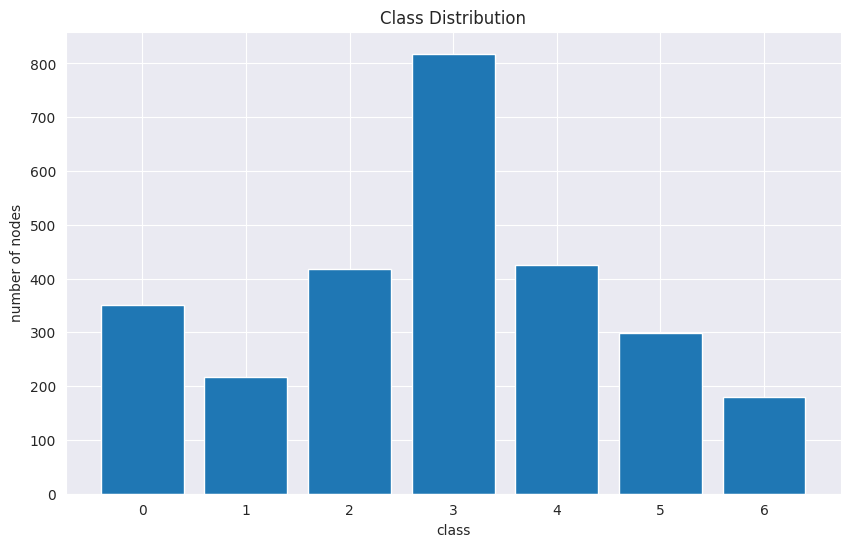

In [ ]:
# Plot the value count for each class
plt.figure(figsize=(10, 6))
plt.bar(counter.keys(), counter.values())
plt.title("Class Distribution")
plt.xlabel("class")
plt.ylabel("number of nodes")
plt.show()

<font color='orange'>Important Note: </font>The highest number of classes is `818` in `class 3`, and the lowest number is `180` in `class 6`. We need to be careful when training machine learning models since there is a label imbalance.

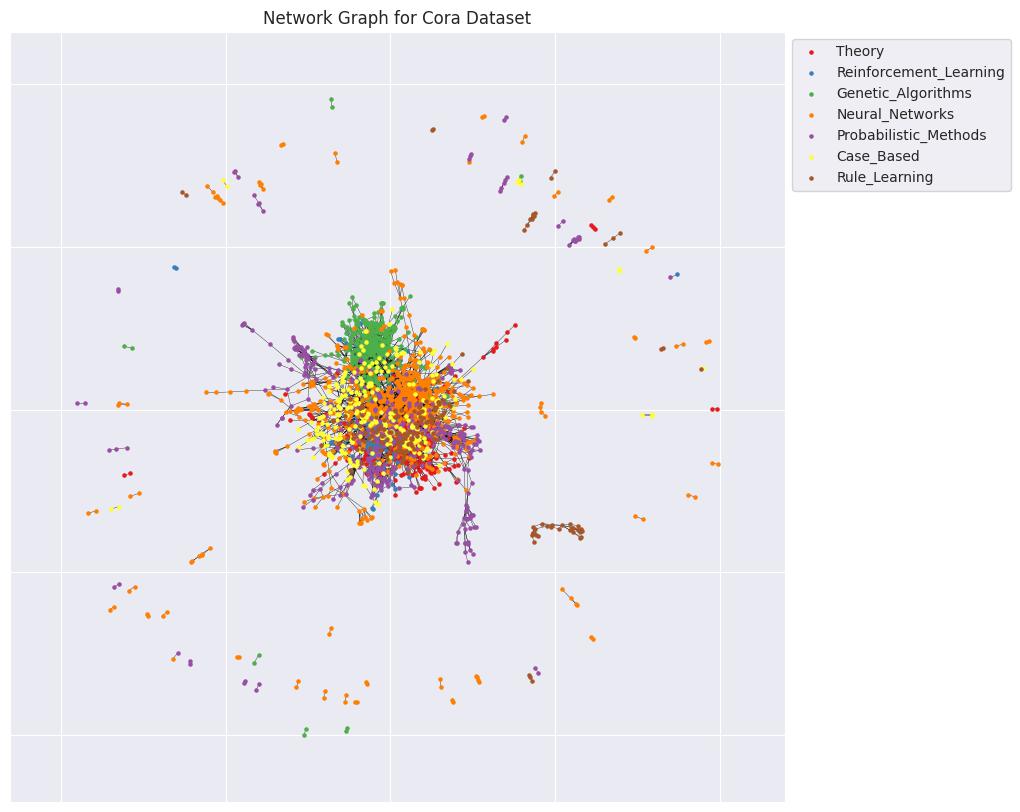

In [ ]:
# Convert data to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Initialize node color list and node lists for different classes
node_color = []
nodelist = [[] for _ in range(7)]  # Create 7 empty lists for the 7 classes
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00', '#984ea3', '#ffff33', '#a65628']

labels = data.y

# Assign colors and group nodes by their labels
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)

# Compute the layout for the graph
pos = nx.spring_layout(G, seed=42)

# Create the figure for the plot
plt.figure(figsize=(10, 10))

# Draw nodes for each class with different colors and labels
labellist = list(label_dict.values())
for num, (nodes, label) in enumerate(zip(nodelist, labellist)):
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=5, node_color=colorlist[num], label=label)

# Draw the edges of the graph
nx.draw_networkx_edges(G, pos, width=0.25)

# Add a title and legend to the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Network Graph for Cora Dataset")

# Display the plot
plt.show()


<font color='orange'>Important Notes:</font> Although it is somewhat challenging to observe in a two-dimensional plot, it appears that the classes are somewhat clustered together.

<font color='magenta'>Caution:</font> Plotly visualization takes time for the execution.

In [ ]:
# # Convert data to a NetworkX graph
# G = to_networkx(data, to_undirected=True)

# # Initialize node color list and node lists for different classes
# node_color = []
# nodelist = [[] for _ in range(7)]  # Create 7 empty lists for the 7 classes
# colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
# labels = data.y

# # Assign colors and group nodes by their labels
# for n, i in enumerate(labels):
#     node_color.append(colorlist[i])
#     nodelist[i].append(n)

# # Compute the layout for the graph
# pos = nx.spring_layout(G, seed=42)

# # Create edge traces
# edge_trace = go.Scatter(
#     x=[],
#     y=[],
#     line=dict(width=0.5, color='#888'),
#     hoverinfo='none',
#     mode='lines')

# for edge in G.edges():
#     x0, y0 = pos[edge[0]]
#     x1, y1 = pos[edge[1]]
#     edge_trace['x'] += (x0, x1, None) # Change from list to tuple
#     edge_trace['y'] += (y0, y1, None) # Change from list to tuple

# # Create node traces for each class
# node_traces = []
# labellist = list(label_dict.values())
# for num, (nodes, label) in enumerate(zip(nodelist, labellist)):
#     node_trace = go.Scatter(
#         x=[],
#         y=[],
#         text=[],
#         mode='markers',
#         hoverinfo='text',
#         marker=dict(
#             showscale=False,
#             color=colorlist[num],
#             size=5,
#             line_width=2),
#         name=label)

#     for node in nodes:
#         x, y = pos[node]
#         node_trace['x'] += [x]
#         node_trace['y'] += [y]
#         node_trace['text'] += [str(node)]  # You can customize what information to display on hover

#     node_traces.append(node_trace)

# # Create the figure
# fig = go.Figure(data=[edge_trace] + node_traces,
#                 layout=go.Layout(
#                     title='<br>Interactive Network Graph',
#                     titlefont_size=16,
#                     showlegend=True,
#                     hovermode='closest',
#                     margin=dict(b=20,l=5,r=5,t=40),
#                     annotations=[dict(
#                         text="Network graph made with Python and Plotly",
#                         showarrow=False,
#                         xref="paper", yref="paper",
#                         x=0.005, y=-0.002)],
#                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
#                 )

# fig.show()

## 6.0 Homophily
In the Cora dataset, we explore the concept of `homophily`, which describes the tendency of nodes with similar characteristics (like research topics) to be connected by edges. We will analyze how frequently nodes from the same class (e.g., computer science) are linked compared to nodes from different classes.

label: 0
1527 edges
{0: 1068, 3: 161, 5: 75, 4: 88, 1: 32, 6: 80, 2: 23}
label: 1
1029 edges
{0: 32, 1: 818, 2: 62, 6: 2, 5: 28, 3: 67, 4: 20}
label: 2
1826 edges
{3: 53, 2: 1654, 5: 30, 0: 23, 1: 62, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 4: 137, 0: 161, 5: 54, 1: 67, 2: 53, 6: 16}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{5: 834, 3: 54, 6: 46, 0: 75, 1: 28, 2: 30, 4: 19}
label: 6
658 edges
{6: 506, 0: 80, 3: 16, 5: 46, 4: 6, 1: 2, 2: 2}


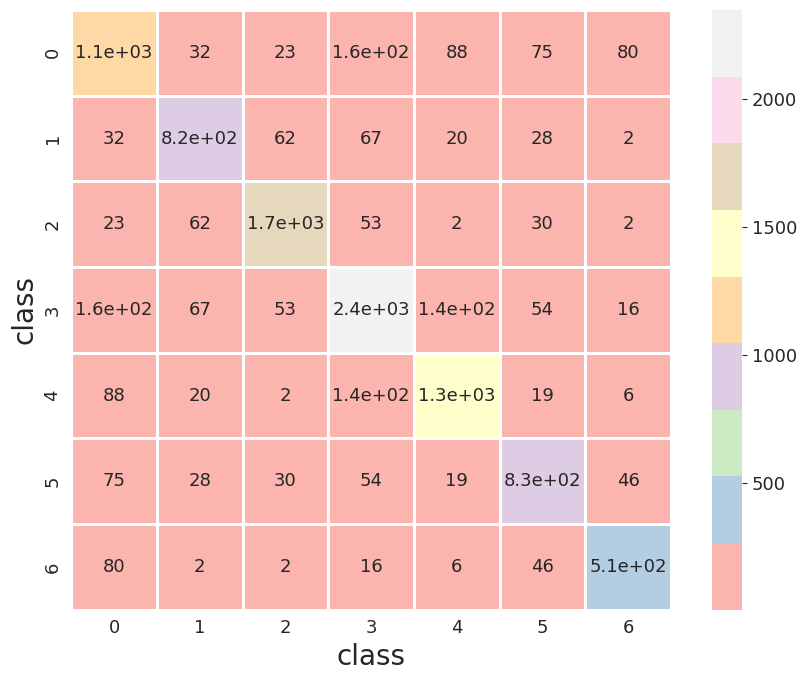

In [ ]:
# Check the relationship between each classes and draw a heatmap
# Convert labels to numpy array
labels = data.y.numpy()

# Map edge indices to their corresponding labels
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)

def add_missing_keys(counter, classes):
    """
    Add missing keys to the counter for classes that are not present.

    Parameters:
    counter (dict): Dictionary with current class counts.
    classes (range): Range of classes to ensure all are present in the counter.

    Returns:
    dict: Updated counter with missing classes set to 0.
    """
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter

label_connection_counts = []

# Iterate over each class label to count connections
for i in range(7):
    print(f"label: {i}")
    # Select edges where the source node has label i
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")

    # Count occurrences of each target node's label
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)

    # Ensure all class labels are present in the counter
    counter = add_missing_keys(counter, range(7))

    # Sort items and extract counts
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)

# Convert list to numpy array for heatmap
label_connection_counts = np.array(label_connection_counts)

# Plot the heatmap
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='Pastel1', cbar=True, square=True, linewidths=1)
plt.xlabel("class", size=20)
plt.ylabel("class", size=20)
plt.tight_layout()
plt.show()

We can see that there are a great many nodes that are connected to each other belonging to the same class.

By dividing the sum of the diagonal components of the matrix by the sum of all components, we calculate the percentage of edges connected within the same class.

In [ ]:
label_connection_counts.diagonal().sum() / label_connection_counts.sum()

0.8099658961727927

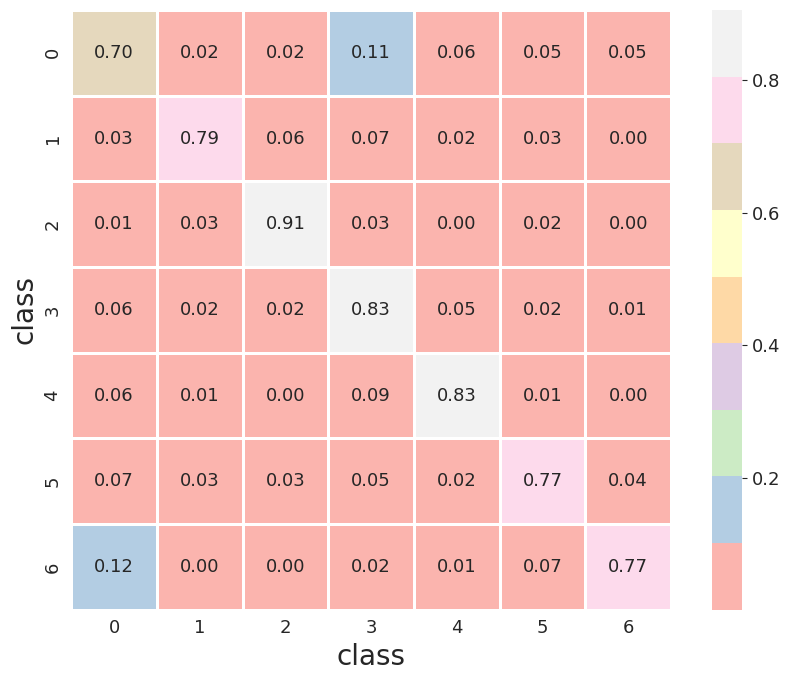

In [ ]:
# Define scaling function to normalize the counts
def scaling(array):
    """
    Normalize the array by dividing each element by the sum of the array.

    Parameters:
    array (numpy.ndarray): Array to be normalized.

    Returns:
    numpy.ndarray: Normalized array.
    """
    return array / sum(array)

# Apply scaling function to each row in label_connection_counts
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)

# Plot the heatmap of scaled connection counts
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='Pastel1',
    fmt="1.2f",  # Format annotations to 2 decimal places
    cbar=True,
    square=True,
    linewidths=1)
plt.xlabel("class", size=20)
plt.ylabel("class", size=20)
plt.tight_layout()
plt.show()

<font color='orange'>Important Note:</font> Our analysis of the adjacency matrix reveals a significant variation in homophily across classes. Class 2 exhibits the strongest homophily, with a staggering 91% of its edges connecting nodes within the same class. Conversely, Class 0 demonstrates a weaker tendency towards homophily, with only 70% of its edges connecting like-minded nodes.

## 7.0 Train Test Split
To ensure robust model evaluation, we will employ a data splitting technique. The provided dataset includes a mask that partitions the data into training, validation, and testing sets. This allows us to train the model on a designated portion of the data, validate its performance on another portion, and ultimately assess its generalizability on unseen data using the testing set.

In [ ]:
# Check the train test split
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Number of validation nodes: {data.val_mask.sum()}")
print(f"Number of testing nodes: {data.test_mask.sum()}")

Number of training nodes: 140
Number of validation nodes: 500
Number of testing nodes: 1000


The data was split into `140 training data`, `500 validation data`, and `1000 test data`. However, the total of these does not add up to 2708 cases.

Training {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
Validation {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
Test {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}


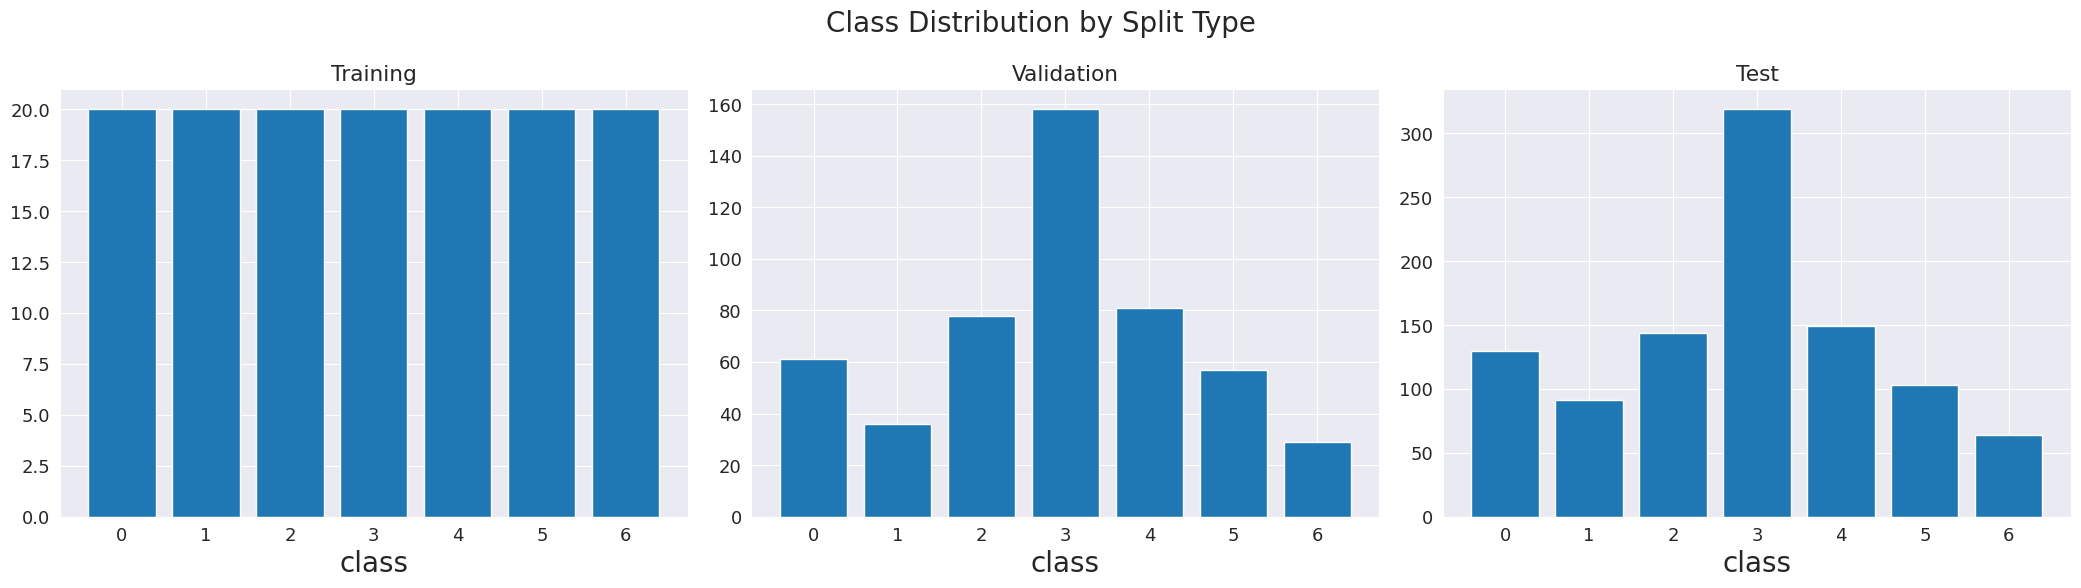

In [ ]:
# Define titles for each dataset split
split_type_array = np.zeros(data.num_nodes)
split_type_array[data.train_mask] = 1
split_type_array[data.val_mask] = 2
split_type_array[data.test_mask] = 3
titles = ["Training", "Validation", "Test"]

# Create subplots with 3 columns for the 3 splits
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))

# Loop through each split type
for i in range(3):
    # Get the labels for the current split type
    split_indices = np.where(split_type_array == i + 1)[0]
    split_labels = data.y.numpy()[split_indices]

    # Count the occurrences of each class label in the current split
    counter = collections.Counter(split_labels)
    counter = dict(counter)
    print(titles[i], counter)

    # Extract counts sorted by class labels
    count = [x[1] for x in sorted(counter.items())]

    # Plot the counts for the current split
    axes[i].bar(range(7), count)
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])

# Adjust the layout and display the plot
plt.suptitle("Class Distribution by Split Type", size=20)
plt.tight_layout()
plt.show()

The `training data` contains `20 data for each class`. The `validation` and `test data` do not have equal proportions of classes, but the two have a `similar distribution`. And these are similar to the percentages of classes in the overall data seen in the Classes section. This observation can be taken into account to decide whether use the initial splitting or we define the splitting ourselves during modelling.